Simple ConvBiGru and ConvBiLSTM

Epoch 1/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3512 - mae: 0.4382
Epoch 1: val_loss improved from inf to 0.13342, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3421 - mae: 0.4309 - val_loss: 0.1334 - val_mae: 0.2506
Epoch 2/30
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1379 - mae: 0.2598
Epoch 2: val_loss improved from 0.13342 to 0.10798, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1379 - mae: 0.2597 - val_loss: 0.1080 - val_mae: 0.2231
Epoch 3/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1289 - mae: 0.2443
Epoch 3: val_loss improved from 0.10798 to 0.07295, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1276 - mae: 0.2431 - val_loss: 0.0730 - val_mae: 0.1896
Epoch 4/30
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0826 - mae: 0.1911
Epoch 4: val_loss improved from 0.07295 to 0.05336, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━

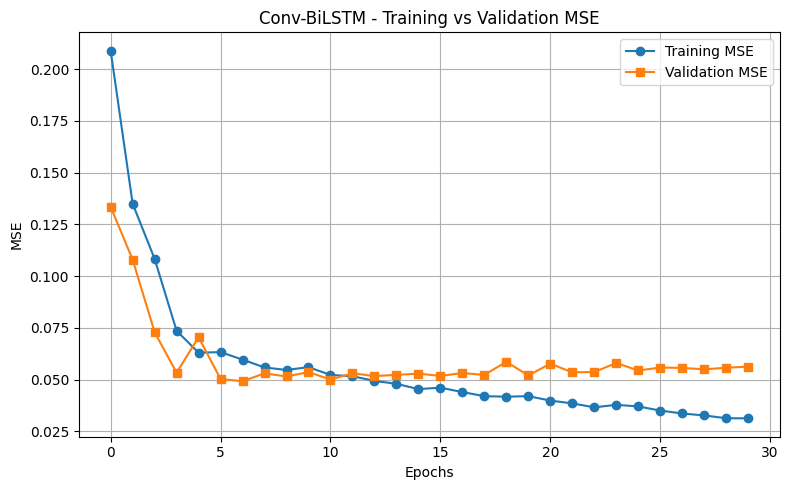

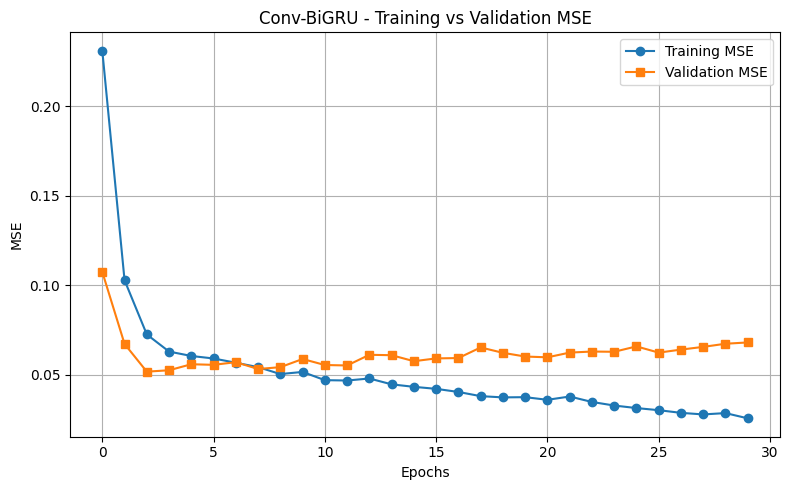

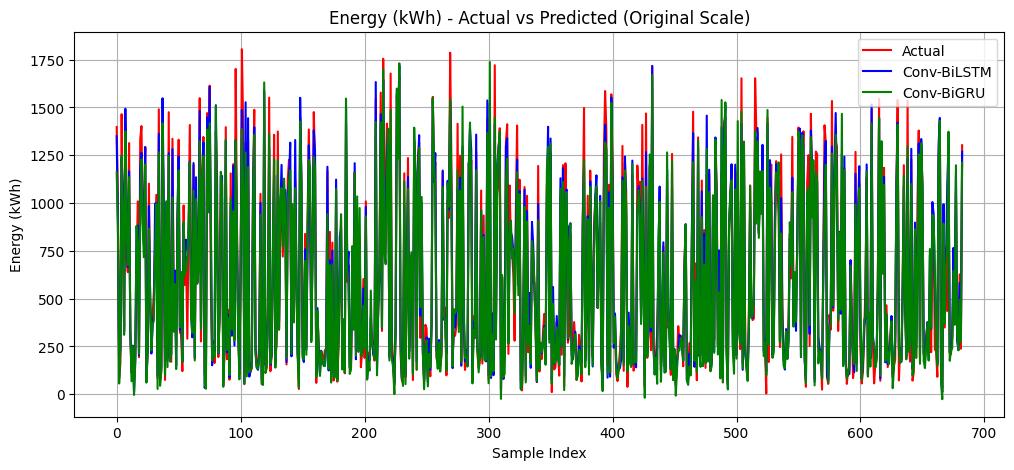

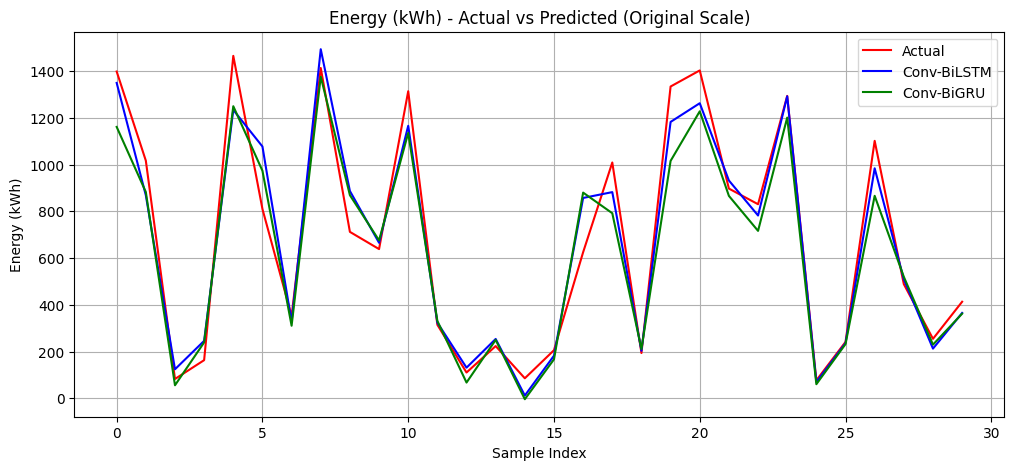

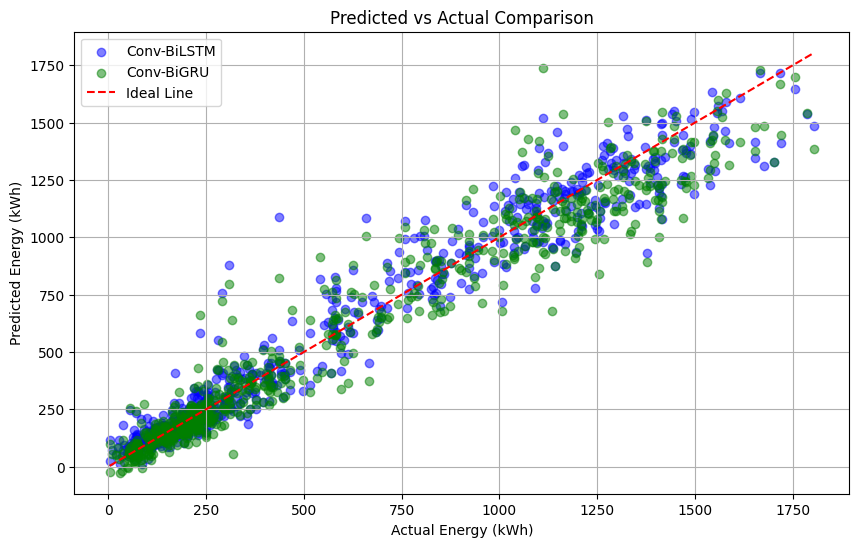

In [18]:
import pandas as pd
import numpy as np
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
from math import sqrt

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Define columns
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude', 'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Charging Time (hours)', 'Total Duration (hours)', 'Fee']
target_col = 'Energy (kWh)'

# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Apply StandardScaler to numerical columns + target
scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Split into X and y
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values

# Sequence creation
def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)

# Train-test split
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

# Embedding configuration
embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

# Build model
def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(1)(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Prepare model input
def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Conv-BiLSTM
model_bilstm = build_model('lstm')
history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Conv-BiGRU
model_bigru = build_model('gru')
history_bigru = model_bigru.fit(train_inputs, y_train, epochs=30, batch_size=32,
                                validation_split=0.1,callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru = model_bigru.predict(test_inputs).flatten()

# Inverse transform predictions to original scale
def inverse_transform(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    return scaler.inverse_transform(combined)[:, -1]

y_test_orig = inverse_transform(y_test)
y_pred_bilstm_orig = inverse_transform(y_pred_bilstm)
y_pred_bigru_orig = inverse_transform(y_pred_bigru)

# Evaluation Function
def evaluate_model(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

    print(f"\n{name} Performance (Original Scale):")
    print(f"  MSE : {mean_squared_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  MAE : {mean_absolute_error(y_test_orig, inverse_transform(y_pred)):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_test_orig, inverse_transform(y_pred))):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_test_orig, inverse_transform(y_pred)) * 100:.6f}")
    print(f"  R²  : {r2_score(y_test_orig, inverse_transform(y_pred)):.6f}")

evaluate_model(y_test, y_pred_bilstm, "Conv-BiLSTM")
evaluate_model(y_test, y_pred_bigru, "Conv-BiGRU")

# Visualization
def plot_training_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title("Energy (kWh) - Actual vs Predicted (Original Scale)")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_curve(history_bilstm, "Conv-BiLSTM")
plot_training_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.2737 - mae: 0.3994
Epoch 1: val_loss improved from inf to 0.11070, saving model to temp_bilstm.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 130ms/step - loss: 0.2711 - mae: 0.3969 - val_loss: 0.1107 - val_mae: 0.2077
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.1005 - mae: 0.2145
Epoch 2: val_loss improved from 0.11070 to 0.08530, saving model to temp_bilstm.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.1003 - mae: 0.2143 - val_loss: 0.0853 - val_mae: 0.1882
Epoch 3/50
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 0.0881 - mae: 0.2026
Epoch 3: val_loss improved from 0.08530 to 0.06177, saving model to temp_bilstm.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0873 - mae: 0.2018 - val_loss: 0.0618 - val_mae: 0.1671
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0523 - mae: 0.1677
Epoch 4: val_loss improved from 0.06177 to 0.02228, saving model to temp_bilstm.keras
39/39 ━━━━━━━━━

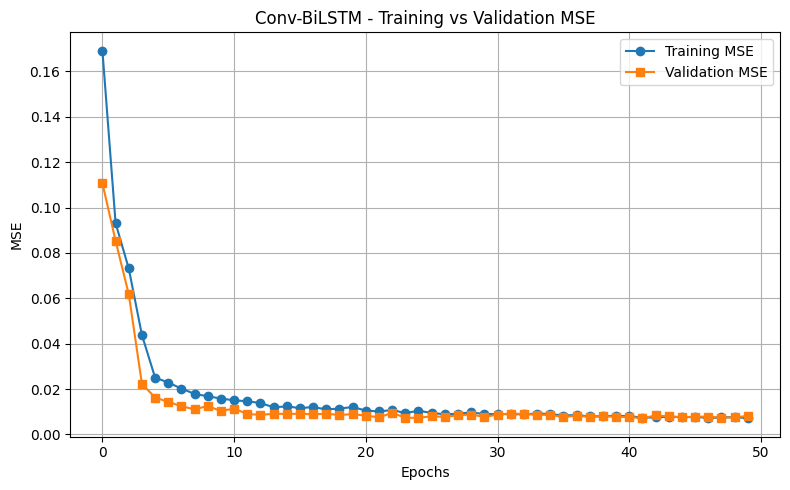

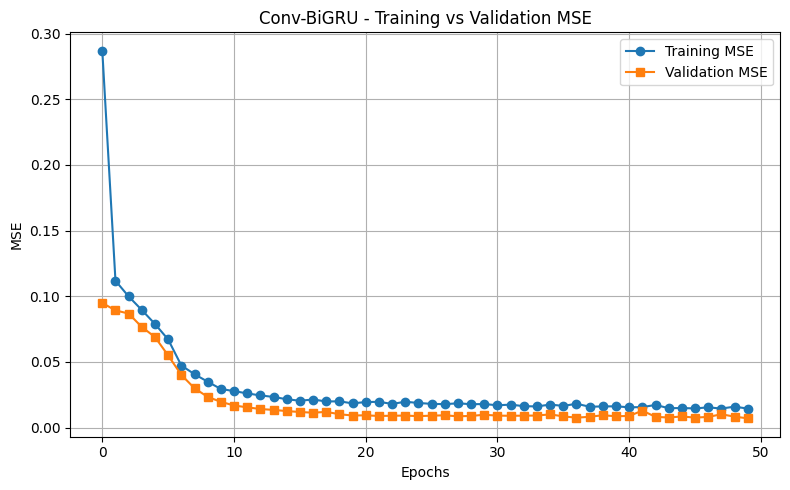

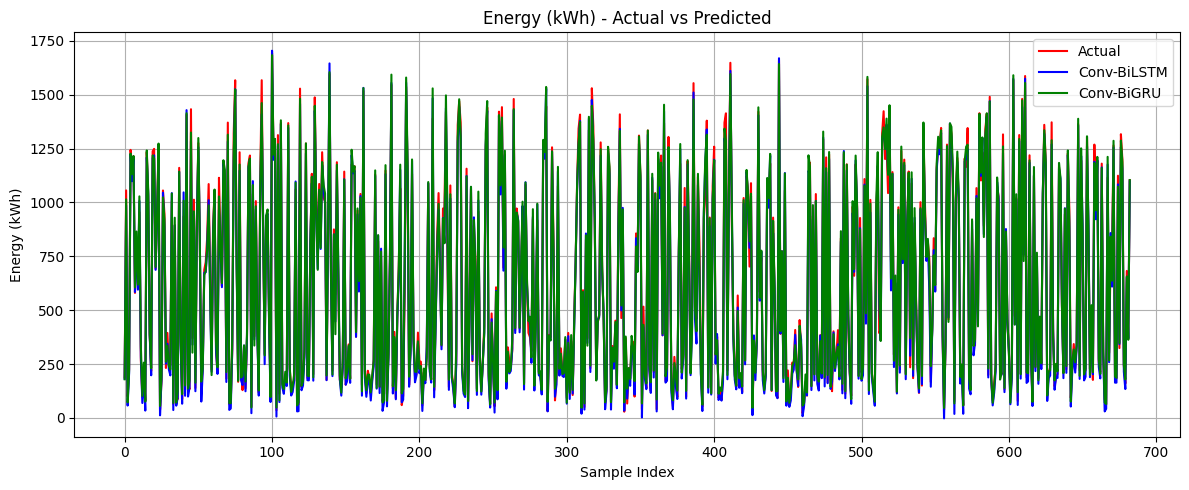

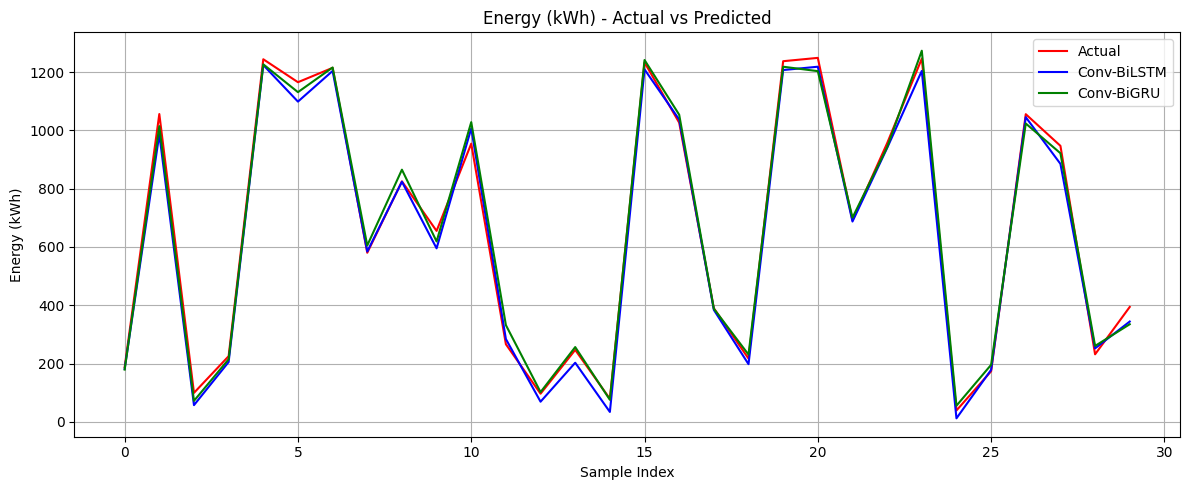

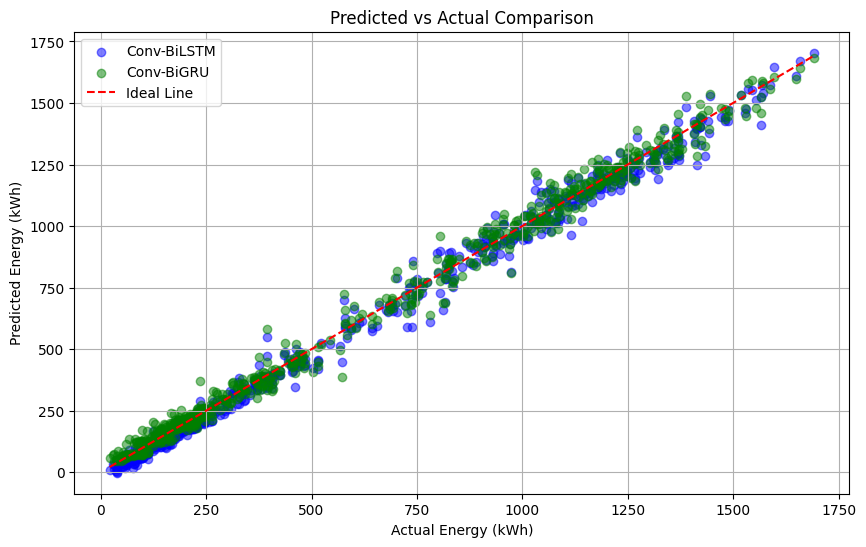

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Step 1: Add lag and rolling features
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Step 2: Define column groups
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# Step 3: Encode and scale
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

# Step 4: Prepare inputs
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

# Step 5: Embedding and model setup
embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Step 6: Define attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

# Step 7: Build model with attention and **fixed hyperparameters**
def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    # 🔥 FIXED hyperparameters per model
    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Step 8: Create models
model_bilstm = build_model('lstm')
model_bigru = build_model('gru')

# Step 9: Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=128,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=64,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

# Delete temp files
for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predictions
y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

# Inverse scaling
def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

# Evaluation normalized scale
def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

# Evaluation original scale
def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

# Print evaluation
evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

# Plot functions
def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Using Rolling and Lag to target feature and Attention Layer with best hyperparameters and GA for time steps selection

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step


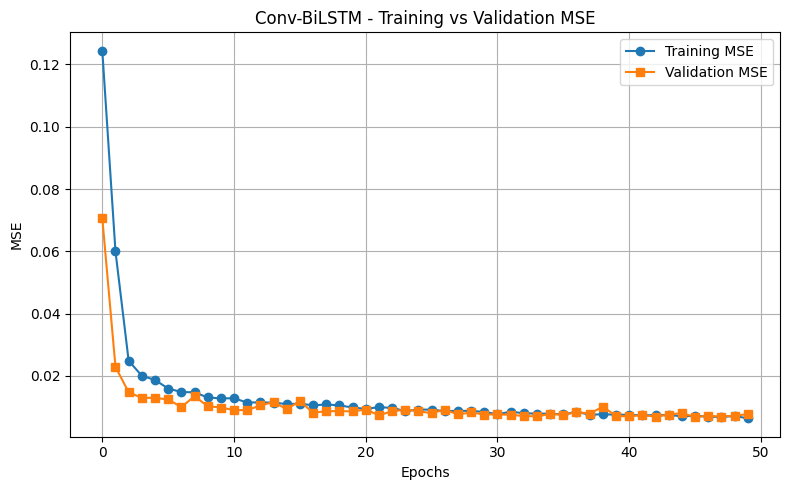

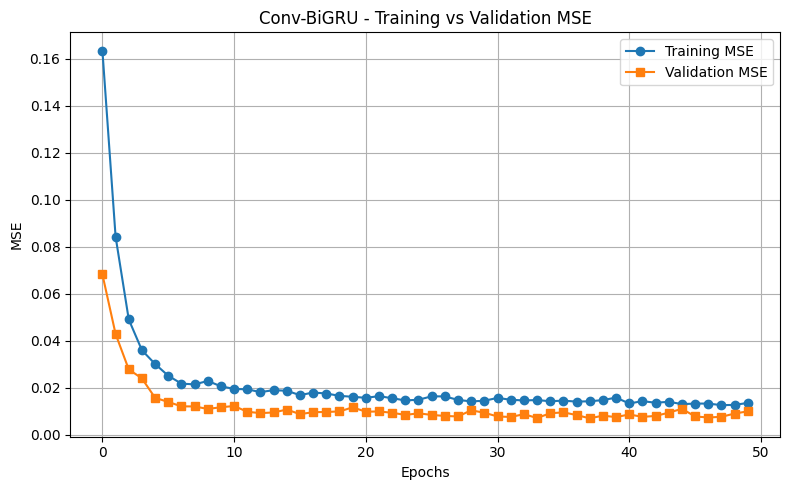

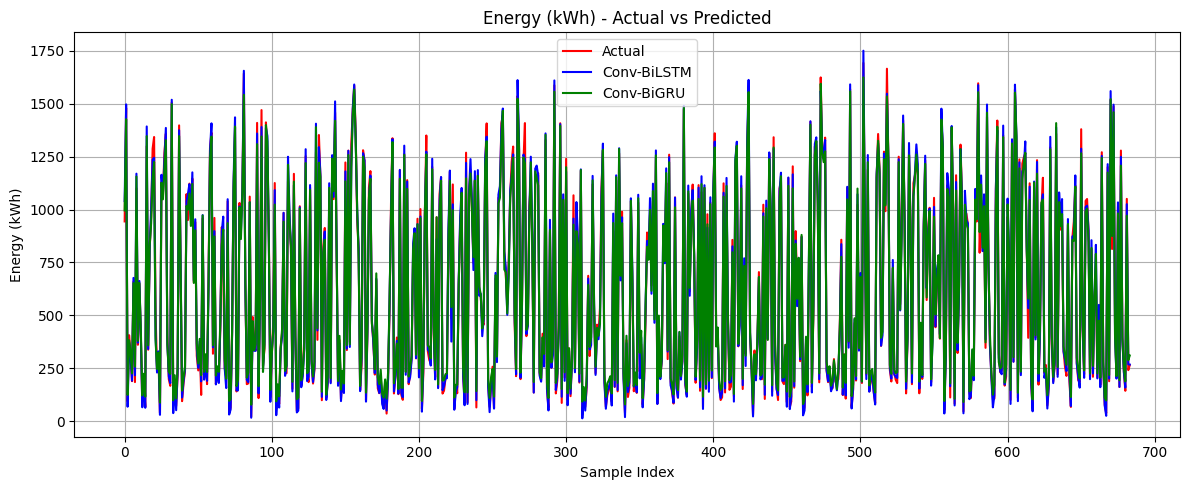

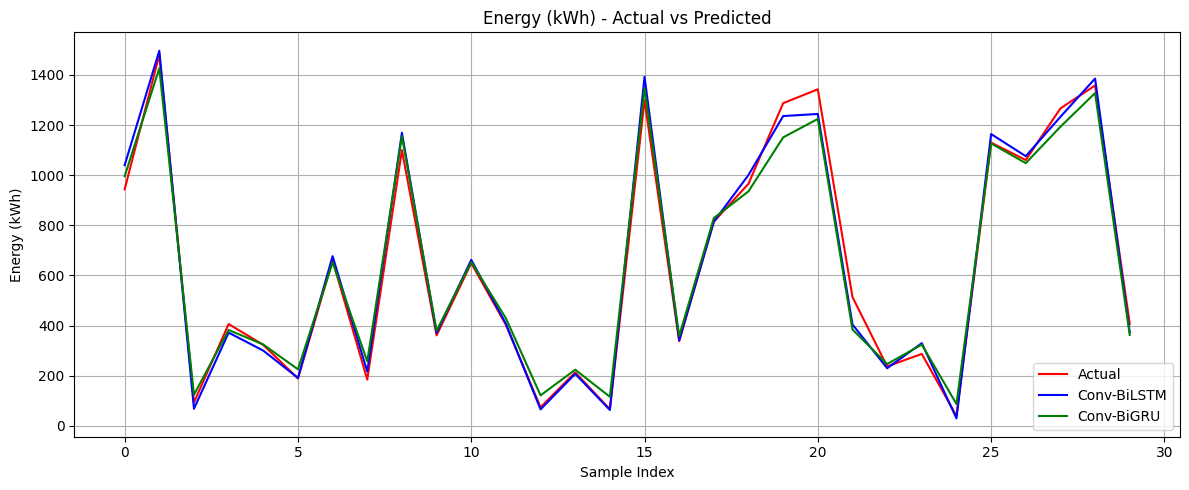

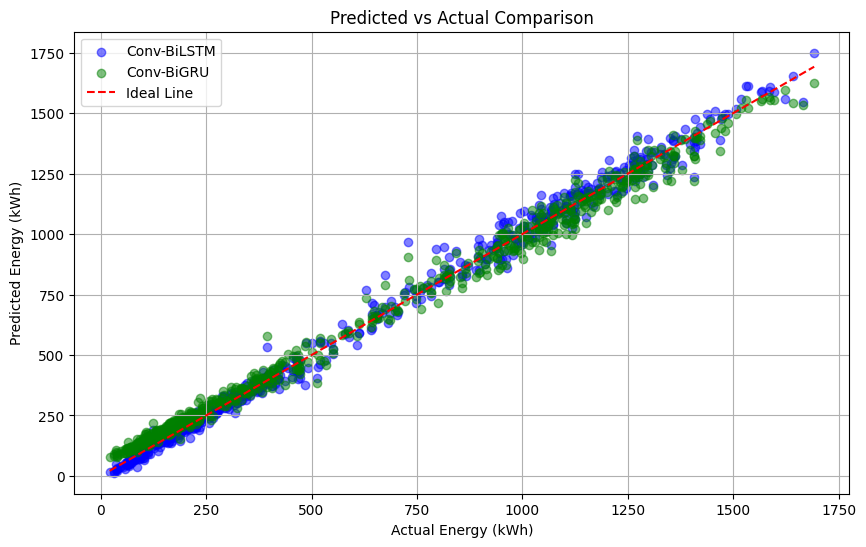

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os
import pygad

# ✅ Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# ✅ Preprocessing
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def create_sequences(X_cat, X_num, y, time_steps):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type, time_steps):
    cat_inputs = [Input(shape=(time_steps,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(time_steps, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = 128
    conv_kernel = 1
    activation_fn = 'selu'
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    if rnn_type == 'lstm':
        rnn_units = 128
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn_units = 80
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629

    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ✅ GA fitness (updated to match Boulder → average LSTM & GRU MSE)
def fitness_func(ga_instance, solution, solution_idx):
    time_steps = int(solution[0])
    X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y, time_steps)
    
    X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
        X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

    train_inputs = prepare_input(X_cat_train, X_num_train)
    test_inputs = prepare_input(X_cat_test, X_num_test)

    model_lstm = build_model('lstm', time_steps)
    model_gru = build_model('gru', time_steps)

    model_lstm.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)
    model_gru.fit(train_inputs, y_train, epochs=10, batch_size=32, validation_split=0.1, verbose=0)

    y_pred_lstm = model_lstm.predict(test_inputs).flatten()
    y_pred_gru = model_gru.predict(test_inputs).flatten()

    mse_lstm = mean_squared_error(y_test, y_pred_lstm)
    mse_gru = mean_squared_error(y_test, y_pred_gru)
    avg_mse = (mse_lstm + mse_gru) / 2

    return -avg_mse

# ✅ Run GA
ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=2,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=1,
    gene_type=int,
    init_range_low=7,
    init_range_high=90,
    gene_space={'low': 7, 'high': 90, 'step': 1},
    mutation_percent_genes=100,
    mutation_type="random"
)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_time_step = int(solution[0])
print(f"\n✅ Best time_steps found: {best_time_step} with fitness {solution_fitness:.6f}")

# ✅ Final training
X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y, best_time_step)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

model_bilstm = build_model('lstm', best_time_step)
model_bigru = build_model('gru', best_time_step)

checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bilstm.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath="temp_bigru.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)

history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

for path in ["temp_bilstm.keras", "temp_bigru.keras"]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

y_pred_bilstm_scaled = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru_scaled = model_bigru.predict(test_inputs).flatten()

def inverse_scaled(pred):
    return target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten()

y_test_orig = inverse_scaled(y_test)
y_pred_bilstm_orig = inverse_scaled(y_pred_bilstm_scaled)
y_pred_bigru_orig = inverse_scaled(y_pred_bigru_scaled)

def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

evaluate_normalized(y_test, y_pred_bilstm_scaled, "Conv-BiLSTM")
evaluate_original(y_test_orig, y_pred_bilstm_orig, "Conv-BiLSTM")
evaluate_normalized(y_test, y_pred_bigru_scaled, "Conv-BiGRU")
evaluate_original(y_test_orig, y_pred_bigru_orig, "Conv-BiGRU")

def plot_training_mse_curve(history, title):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training MSE', marker='o')
    plt.plot(history.history['val_loss'], label='Validation MSE', marker='s')
    plt.title(f"{title} - Training vs Validation MSE")
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_true, sample, y_pred1, y_pred2):
    plt.figure(figsize=(12, 5))
    plt.plot(y_true[:sample], label='Actual', color='red')
    plt.plot(y_pred1[:sample], label='Conv-BiLSTM', color='blue')
    plt.plot(y_pred2[:sample], label='Conv-BiGRU', color='green')
    plt.title(f"Energy (kWh) - Actual vs Predicted")
    plt.xlabel("Sample Index")
    plt.ylabel("Energy (kWh)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_predicted_vs_actual_combined(y_true, y_pred_bilstm, y_pred_bigru, title="Predicted vs Actual Comparison"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred_bilstm, color='blue', alpha=0.5, label='Conv-BiLSTM')
    plt.scatter(y_true, y_pred_bigru, color='green', alpha=0.5, label='Conv-BiGRU')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--', label='Ideal Line')
    plt.xlabel('Actual Energy (kWh)')
    plt.ylabel('Predicted Energy (kWh)')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_mse_curve(history_bilstm, "Conv-BiLSTM")
plot_training_mse_curve(history_bigru, "Conv-BiGRU")
plot_predictions(y_test_orig, len(y_test_orig), y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predictions(y_test_orig, 30, y_pred_bilstm_orig, y_pred_bigru_orig)
plot_predicted_vs_actual_combined(y_test_orig, y_pred_bilstm_orig, y_pred_bigru_orig)


Steady State GA

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os
import pygad

# ✅ Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# ✅ Feature engineering
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

def create_sequences(X_cat, X_num, y, time_steps):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(time_steps, rnn_type='lstm'):
    cat_inputs = [Input(shape=(time_steps,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(time_steps, len(numerical_cols)), name="numerical_input")
    
    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)
    
    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=128, kernel_size=1, activation='selu')(merged)
    
    if rnn_type == 'lstm':
        rnn = Bidirectional(LSTM(128, return_sequences=True))(conv)
        dropout_rate = 0.3
        learning_rate = 0.0006111477901954563
    else:
        rnn = Bidirectional(GRU(80, return_sequences=True))(conv)
        dropout_rate = 0.5
        learning_rate = 0.0008209165372637629
    
    attention = AttentionLayer()(rnn)
    x = Dropout(dropout_rate)(attention)
    output = Dense(1)(x)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ✅ Fitness function with early stopping
def fitness_func(ga_instance, solution, solution_idx):
    time_steps = int(solution[0])
    X_cat_seq, X_num_seq, y_seq = create_sequences(df[categorical_cols].values, df[numerical_cols].values, df['target_scaled'].values, time_steps)
    
    if len(X_cat_seq) < 100:
        return -1e9  # skip
    
    X_cat_train, X_cat_val, X_num_train, X_num_val, y_train, y_val = train_test_split(
        X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)
    
    train_inputs = prepare_input(X_cat_train, X_num_train)
    val_inputs = prepare_input(X_cat_val, X_num_val)
    
    model = build_model(time_steps, 'lstm')
    early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    
    history = model.fit(train_inputs, y_train, epochs=30, batch_size=32, validation_data=(val_inputs, y_val),
                        callbacks=[early_stop], verbose=0)
    
    val_loss = history.history['val_loss'][-1]
    return -val_loss

# ✅ Steady-State GA with elitism
ga_instance = pygad.GA(
    num_generations=10,
    num_parents_mating=2,
    fitness_func=fitness_func,
    sol_per_pop=5,
    num_genes=1,
    gene_type=int,
    init_range_low=7,
    init_range_high=90,
    gene_space={'low': 7, 'high': 90, 'step': 1},
    keep_parents=1,        # ✅ elitism: keep best
    mutation_percent_genes=100,
    mutation_type="random"
)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
best_time_step = int(solution[0])
print(f"\n✅ Best time_steps found: {best_time_step} with fitness {solution_fitness:.6f}")




✅ Best time_steps found: 28 with fitness -0.006066


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import keras_tuner as kt
import os

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Add lag and rolling features
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define columns
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# Encode and scale
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

# Prepare input arrays
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

# ✅ PREPARE INPUTS AS LIST
train_inputs_list = [X_cat_train[:, :, i] for i in range(len(categorical_cols))] + [X_num_train]
test_inputs_list = [X_cat_test[:, :, i] for i in range(len(categorical_cols))] + [X_num_test]

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

# ✅ BUILD MODEL FUNCTION: for LSTM or GRU
def build_model(hp, rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = hp.Int("conv_filters", min_value=16, max_value=128, step=16)
    conv_kernel = hp.Choice("conv_kernel", [1, 3, 5])
    activation_fn = hp.Choice("activation_fn", ["relu", "tanh", "selu"])
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    rnn_units = hp.Int("rnn_units", min_value=32, max_value=128, step=16)
    if rnn_type == 'lstm':
        rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)
    else:
        rnn = Bidirectional(GRU(rnn_units, return_sequences=True))(conv)

    attention = AttentionLayer()(rnn)

    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(attention)

    output = Dense(1)(x)

    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# ✅ TUNER FUNCTION for specific rnn_type
def tune_model(rnn_type):
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, rnn_type),
        objective='val_loss',
        max_trials=20,
        executions_per_trial=1,
        overwrite=True,
        directory='hyperparam_tuning',
        project_name=f'energy_forecasting_{rnn_type}'
    )

    batch_sizes = [16, 32, 64]
    for batch_size in batch_sizes:
        print(f"\n🔍 Tuning {rnn_type.upper()} with batch size {batch_size}")
        tuner.search(train_inputs_list, y_train, epochs=30, validation_split=0.1, batch_size=batch_size, verbose=2)

    best_model = tuner.get_best_models(num_models=1)[0]
    best_hyperparams = tuner.get_best_hyperparameters(1)[0]

    print(f"\n✅ Best Hyperparameters for {rnn_type.upper()}:")
    for param in best_hyperparams.values.keys():
        print(f"{param}: {best_hyperparams.get(param)}")

    y_pred_scaled = best_model.predict(test_inputs_list).flatten()
    y_pred_orig = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    print(f"\n📊 Best {rnn_type.upper()} Model Performance (Original Scale):")
    print(f"MSE : {mean_squared_error(y_test_orig, y_pred_orig):.6f}")
    print(f"MAE : {mean_absolute_error(y_test_orig, y_pred_orig):.6f}")
    print(f"RMSE: {sqrt(mean_squared_error(y_test_orig, y_pred_orig)):.6f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100:.6f}")
    print(f"R²  : {r2_score(y_test_orig, y_pred_orig):.6f}")

# ✅ TUNE BOTH LSTM AND GRU
#tune_model('lstm')
tune_model('gru')


Trial 20 Complete [00h 00m 53s]
val_loss: 0.0909682884812355

Best val_loss So Far: 0.008051921613514423
Total elapsed time: 00h 20m 47s

🔍 Tuning GRU with batch size 32

🔍 Tuning GRU with batch size 64


d:\VS Code\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 27 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



✅ Best Hyperparameters for GRU:
conv_filters: 112
conv_kernel: 1
activation_fn: relu
rnn_units: 80
dropout_rate: 0.30000000000000004
optimizer: rmsprop
learning_rate: 0.0010162725513446582
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Best GRU Model Performance (Original Scale):
MSE : 1714.191437
MAE : 29.494412
RMSE: 41.402795
MAPE: 8.954733
R²  : 0.992233


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, TimeDistributed
import keras_tuner as kt
import os

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Add lag and rolling features
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()

df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define columns
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# Encode and scale
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['target_scaled'] = target_scaler.fit_transform(df[['smooth_target']])

# Prepare input arrays
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

# PREPARE INPUTS AS LIST
train_inputs_list = [X_cat_train[:, :, i] for i in range(len(categorical_cols))] + [X_num_train]
test_inputs_list = [X_cat_test[:, :, i] for i in range(len(categorical_cols))] + [X_num_test]

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(hp):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])

    conv_filters = hp.Int("conv_filters", min_value=16, max_value=128, step=16)
    conv_kernel = hp.Choice("conv_kernel", [1, 3, 5])
    activation_fn = hp.Choice("activation_fn", ["relu", "tanh", "selu"])
    conv = Conv1D(filters=conv_filters, kernel_size=conv_kernel, activation=activation_fn)(merged)

    rnn_units = hp.Int("rnn_units", min_value=32, max_value=128, step=16)
    rnn = Bidirectional(LSTM(rnn_units, return_sequences=True))(conv)

    attention = AttentionLayer()(rnn)

    dropout_rate = hp.Float("dropout_rate", min_value=0.1, max_value=0.5, step=0.1)
    x = Dropout(dropout_rate)(attention)

    output = Dense(1)(x)

    optimizer_choice = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])
    learning_rate = hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")
    if optimizer_choice == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True,
    directory='hyperparam_tuning',
    project_name='energy_forecasting_lstm'
)

batch_sizes = [16, 32, 64]
for batch_size in batch_sizes:
    print(f"\n🔍 Tuning LSTM with batch size {batch_size}")
    tuner.search(train_inputs_list, y_train, epochs=30, validation_split=0.1, batch_size=batch_size, verbose=2)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(1)[0]

print("\n✅ Best Hyperparameters for LSTM:")
for param in best_hyperparams.values.keys():
    print(f"{param}: {best_hyperparams.get(param)}")

y_pred_scaled = best_model.predict(test_inputs_list).flatten()
y_pred_orig = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_orig = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("\n📊 Best LSTM Model Performance (Original Scale):")
print(f"MSE : {mean_squared_error(y_test_orig, y_pred_orig):.6f}")
print(f"MAE : {mean_absolute_error(y_test_orig, y_pred_orig):.6f}")
print(f"RMSE: {sqrt(mean_squared_error(y_test_orig, y_pred_orig)):.6f}")
print(f"MAPE: {mean_absolute_percentage_error(y_test_orig, y_pred_orig) * 100:.6f}")
print(f"R²  : {r2_score(y_test_orig, y_pred_orig):.6f}")


Trial 20 Complete [00h 00m 44s]
val_loss: 0.008207271806895733

Best val_loss So Far: 0.006924180779606104
Total elapsed time: 00h 14m 15s

🔍 Tuning LSTM with batch size 32

🔍 Tuning LSTM with batch size 64


d:\VS Code\.venv\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 52 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



✅ Best Hyperparameters for LSTM:
conv_filters: 128
conv_kernel: 1
activation_fn: selu
rnn_units: 128
dropout_rate: 0.30000000000000004
optimizer: adam
learning_rate: 0.0006111477901954563
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

📊 Best LSTM Model Performance (Original Scale):
MSE : 1795.691641
MAE : 29.390797
RMSE: 42.375602
MAPE: 7.468455
R²  : 0.991864


Peak Day Prediction using 7 day forecast

Epoch 1/80
72/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.3514
Epoch 1: val_loss improved from inf to 0.08317, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3387 - val_loss: 0.0832
Epoch 2/80
73/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0905
Epoch 2: val_loss improved from 0.08317 to 0.05734, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0902 - val_loss: 0.0573
Epoch 3/80
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0737
Epoch 3: val_loss improved from 0.05734 to 0.04952, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0736 - val_loss: 0.0495
Epoch 4/80
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0585
Epoch 4: val_loss improved from 0.04952 to 0.04090, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0585 - val_loss: 0.0409
Epoch 5/80
71/77 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0500
Epoch 5: val_loss improved from 0.04090

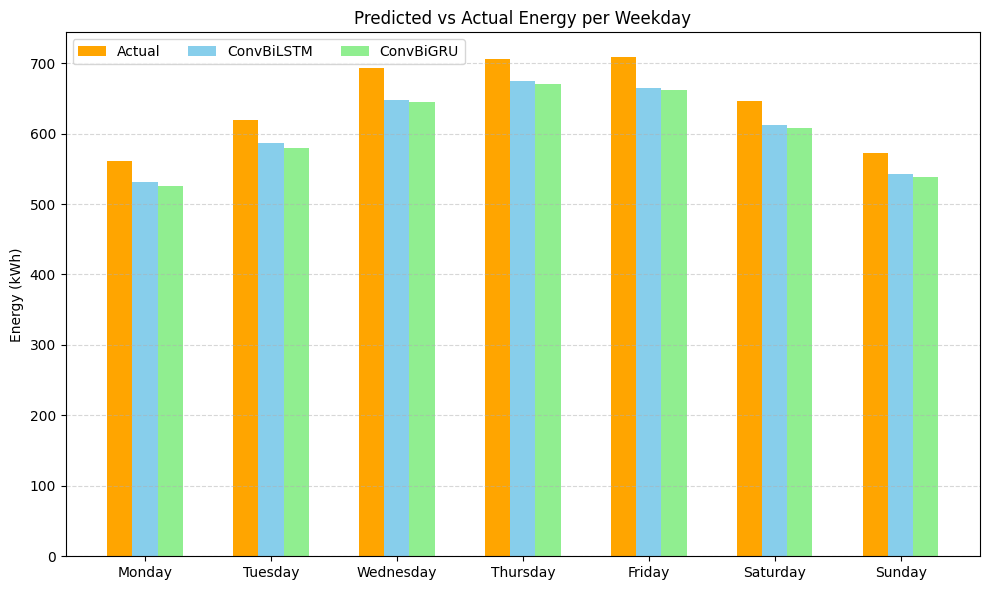

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import matplotlib.pyplot as plt
from math import sqrt
import os

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Define columns
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code',
                    'Latitude', 'Longitude', 'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Charging Time (hours)', 'Total Duration (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']
target_col = 'smooth_target'

# Label encode categorical columns
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col].astype(str))

# Apply StandardScaler to numerical columns + target
scaler = StandardScaler()
df[numerical_cols + [target_col]] = scaler.fit_transform(df[numerical_cols + [target_col]])

# Sequence data
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df[target_col].values
dow = df['Day of Week'].values

def create_7day_sequences(X_cat, X_num, y, dow, time_steps=30):
    Xs_cat, Xs_num, ys, dows = [], [], [], []
    for i in range(len(X_cat) - time_steps - 7):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps:i + time_steps + 7])
        dows.append(dow[i + time_steps:i + time_steps + 7])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys), np.array(dows)

X_cat_seq, X_num_seq, y_seq, dow_seq = create_7day_sequences(X_cat, X_num, y, dow)

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test, dow_train, dow_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, dow_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")
    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)
    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)
    rnn = Bidirectional(LSTM(64, return_sequences=False) if rnn_type == 'lstm' else GRU(64, return_sequences=False))(conv)
    x = Dropout(0.2)(rnn)
    output = Dense(7)(x)
    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse')
    return model

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Train Conv-BiLSTM
model_bilstm = build_model('lstm')
model_bilstm.fit(train_inputs, y_train, epochs=80, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Train Conv-BiGRU
model_bigru = build_model('gru')
model_bigru.fit(train_inputs, y_train, epochs=80, batch_size=32, validation_split=0.1, callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Predict
y_pred_bilstm_scaled = model_bilstm.predict(test_inputs)
y_pred_bigru_scaled = model_bigru.predict(test_inputs)

# Inverse transform predictions
def inverse_transform_7day(predictions):
    restored = []
    for i in range(predictions.shape[1]):
        pad = np.zeros((len(predictions), len(numerical_cols)))
        combined = np.hstack((pad, predictions[:, i:i+1]))
        restored_kwh = scaler.inverse_transform(combined)[:, -1]
        restored.append(restored_kwh)
    return np.stack(restored, axis=1)

y_pred_bilstm_kwh = inverse_transform_7day(y_pred_bilstm_scaled)
y_pred_bigru_kwh = inverse_transform_7day(y_pred_bigru_scaled)

# Aggregate predicted energy by weekday
weekday_energy_bilstm = {i: [] for i in range(7)}
weekday_energy_bigru = {i: [] for i in range(7)}

for i in range(len(dow_test)):
    for d, e1, e2 in zip(dow_test[i], y_pred_bilstm_kwh[i], y_pred_bigru_kwh[i]):
        weekday_energy_bilstm[d].append(e1)
        weekday_energy_bigru[d].append(e2)

# Calculate average and total energy
avg_kwh_bilstm = {d: np.mean(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
avg_kwh_bigru = {d: np.mean(weekday_energy_bigru[d]) for d in weekday_energy_bigru}
total_kwh_bilstm = {d: np.sum(weekday_energy_bilstm[d]) for d in weekday_energy_bilstm}
total_kwh_bigru = {d: np.sum(weekday_energy_bigru[d]) for d in weekday_energy_bigru}

# Calculate actual average energy per weekday (from the original dataset)
def inverse_transform_actual(scaled_y):
    pad = np.zeros((len(scaled_y), len(numerical_cols)))
    combined = np.hstack((pad, scaled_y.reshape(-1, 1)))
    restored_kwh = scaler.inverse_transform(combined)[:, -1]
    return restored_kwh

df['Actual_Energy'] = inverse_transform_actual(df[target_col].values)

# Now, calculate the average energy per weekday
actual_avg_kwh = {i: np.mean(df[df['Day of Week'] == i]['Actual_Energy']) for i in range(7)}

# Create readable DataFrame with actual values
df_summary = pd.DataFrame({
    'Weekday': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    'Avg_kWh_BiLSTM': [avg_kwh_bilstm[i] for i in range(7)],
    'Avg_kWh_BiGRU': [avg_kwh_bigru[i] for i in range(7)],
    'Actual_Avg_kWh': [actual_avg_kwh[i] for i in range(7)],
    'Total_kWh_BiLSTM': [total_kwh_bilstm[i] for i in range(7)],
    'Total_kWh_BiGRU': [total_kwh_bigru[i] for i in range(7)]
  
})

print("\n📋 Predicted and Actual Energy Summary per Weekday:")
print(df_summary)

# Optional: plot side-by-side average with actual energy values
plt.figure(figsize=(10, 6))
x = np.arange(7)
bar_width = 0.2
plt.bar(x - bar_width, df_summary['Actual_Avg_kWh'], width=bar_width, label='Actual', color='orange')
plt.bar(x, df_summary['Avg_kWh_BiLSTM'], width=bar_width, label='ConvBiLSTM', color='skyblue')
plt.bar(x + bar_width, df_summary['Avg_kWh_BiGRU'], width=bar_width, label='ConvBiGRU', color='lightgreen')
plt.xticks(x, df_summary['Weekday'])
plt.ylabel("Energy (kWh)")
plt.title("Predicted vs Actual Energy per Weekday")
plt.legend(loc='upper left', ncol=3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


ConvLSTM-BiLSTM Encoder Decoder

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, Bidirectional, LSTM
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Step 1: Load CSV
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Step 2: Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 3: Separate features and target
features = df.drop(columns=['Energy (kWh)'])
target = df['Energy (kWh)']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # shape = (time, rows=1, cols=n_features, channels=1)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build ConvLSTM → BiLSTM Model
def build_conv_bilstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False)(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = Bidirectional(LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001)))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_conv_bilstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Predict and Reshape Output
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)
y_true = y_test

# 11. Evaluation Metrics
def evaluate_model(y_true, y_pred, name="ConvLSTM-BiLSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance (7-Day Forecast):")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_true, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='blue')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


ConvBiLSTM-LSTM encoder-decoder

Epoch 1/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 8s 115ms/step - loss: 1.5363 - mae: 0.5895 - val_loss: 0.4584 - val_mae: 0.2821
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 96ms/step - loss: 0.3855 - mae: 0.2717 - val_loss: 0.2821 - val_mae: 0.2689
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: 0.2628 - mae: 0.2661 - val_loss: 0.2200 - val_mae: 0.2504
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.2211 - mae: 0.2633 - val_loss: 0.1964 - val_mae: 0.2445
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.1925 - mae: 0.2499 - val_loss: 0.1769 - val_mae: 0.2459
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: 0.1768 - mae: 0.2476 - val_loss: 0.1727 - val_mae: 0.2535
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.1647 - mae: 0.2407 - val_loss: 0.1640 - val_mae: 0.2458
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.1586 - mae: 0.2381 - val_loss: 0.1531 - val_mae: 0.2369
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.14

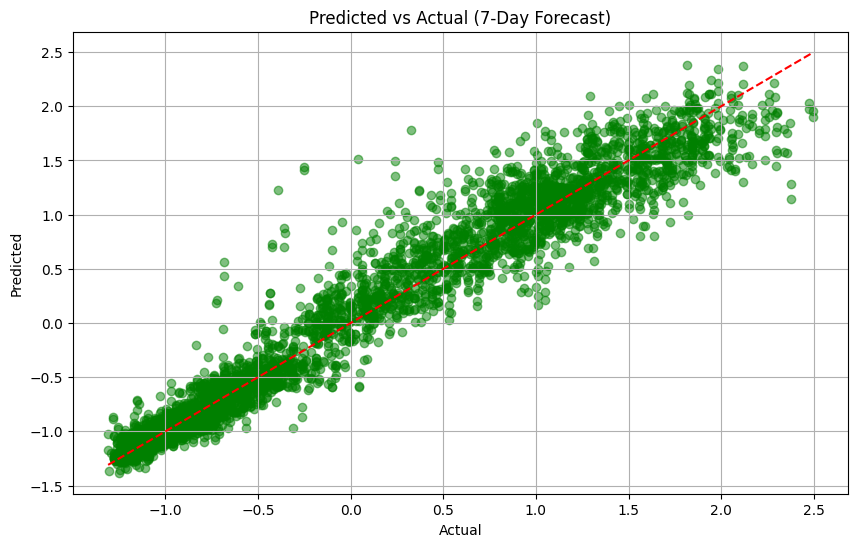

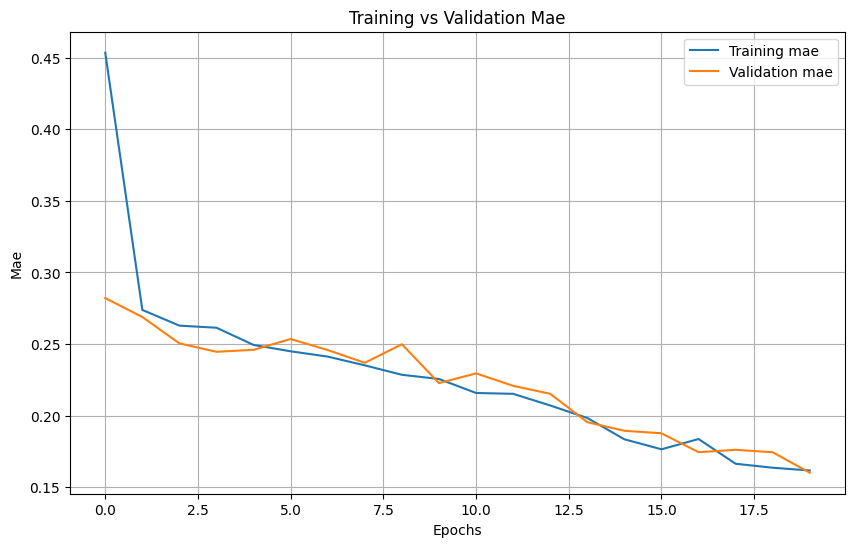

In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, TimeDistributed, Dense, Flatten, RepeatVector, LSTM, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Step 1: Load CSV
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Step 2: Label Encode Categorical Columns
for col in df.select_dtypes(include='object').columns:
    df[col] = LabelEncoder().fit_transform(df[col])

# Step 3: Separate features and target
features = df.drop(columns=['Energy (kWh)'])
target = df['Energy (kWh)']

# 5. Normalize Features and Target
feature_scaler = StandardScaler()
features_scaled = feature_scaler.fit_transform(features)

target_scaler = StandardScaler()
target_scaled = target_scaler.fit_transform(target.values.reshape(-1, 1)).flatten()

# 6. Create Sequences for 7-Day Forecasting
def create_sequences(X, y, time_steps=30, forecast_horizon=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - forecast_horizon + 1):
        seq = X[i:i + time_steps]
        seq = seq.reshape((time_steps, 1, X.shape[1], 1))  # (t, rows, cols, ch)
        Xs.append(seq)
        ys.append(y[i + time_steps:i + time_steps + forecast_horizon])
    return np.array(Xs), np.array(ys)

time_steps = 30
forecast_horizon = 7
X, y = create_sequences(features_scaled, target_scaled, time_steps, forecast_horizon)

# 7. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 8. Build BiConvLSTM → LSTM Model
def build_biconvlstm_lstm_model(input_shape, forecast_horizon):
    inputs = Input(shape=input_shape)
    x = Bidirectional(ConvLSTM2D(filters=64, kernel_size=(1, 3), activation='relu', return_sequences=False))(inputs)
    x = Flatten()(x)
    x = RepeatVector(forecast_horizon)(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = LSTM(200, activation='relu', return_sequences=True, kernel_regularizer=l2(0.001))(x)
    x = TimeDistributed(Dense(100, activation='relu'))(x)
    outputs = TimeDistributed(Dense(1))(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])
    return model

model = build_biconvlstm_lstm_model(X_train.shape[1:], forecast_horizon)

# 9. Train the Model
history = model.fit(
    X_train, y_train.reshape(-1, forecast_horizon, 1),
    epochs=20,
    batch_size=64,
    validation_split=0.1,
    verbose=1
)

# 10. Prediction
y_pred = model.predict(X_test).reshape(-1, forecast_horizon)

# 11. Evaluation
def evaluate_model(y_true, y_pred, name="BiConvLSTM-LSTM"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Performance:")
    print(f"  MSE : {mse:.6f}")
    print(f"  MAE : {mae:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAPE: {mape:.6f}%")
    print(f"  R² Score: {r2:.4f}")

evaluate_model(y_test, y_pred)

# 12. Plotting
def plot_predicted_vs_actual(y_true, y_pred, title="Predicted vs Actual (7-Day Forecast)"):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.5, color='green')
    plt.plot([min(y_true.flatten()), max(y_true.flatten())],
             [min(y_true.flatten()), max(y_true.flatten())],
             color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_training_validation_curve(history, metric='loss'):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training vs Validation {metric.capitalize()}')
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

# 13. Display Graphs
plot_predicted_vs_actual(y_test, y_pred)
plot_training_validation_curve(history, 'mae')


Using Permutaion Importance

Epoch 1/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.2048 - mae: 0.3219 - val_loss: 0.0433 - val_mae: 0.1466
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0547 - mae: 0.1706 - val_loss: 0.0389 - val_mae: 0.1438
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0500 - mae: 0.1646 - val_loss: 0.0317 - val_mae: 0.1354
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0401 - mae: 0.1489 - val_loss: 0.0207 - val_mae: 0.1047
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0297 - mae: 0.1251 - val_loss: 0.0193 - val_mae: 0.1036
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0319 - mae: 0.1243 - val_loss: 0.0184 - val_mae: 0.0982
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0307 - mae: 0.1218 - val_loss: 0.0175 - val_mae: 0.0937
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0247 - mae: 0.1107 - val_loss: 0.0140 - val_mae: 0.0862
Epoch 9/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.023

C:\Users\user\AppData\Local\Temp\ipykernel_16992\2183595458.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y="Feature", x="Importance", data=importance_df, palette="viridis", edgecolor="black")


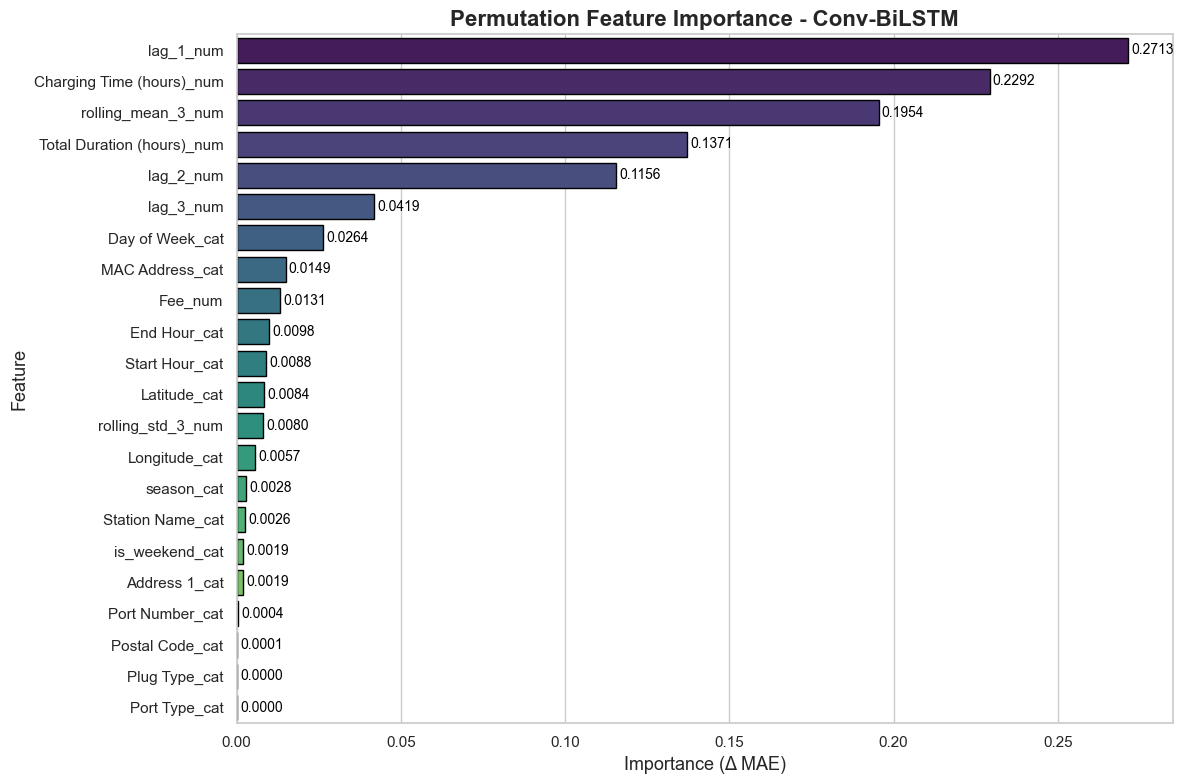

C:\Users\user\AppData\Local\Temp\ipykernel_16992\2183595458.py:151: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y="Feature", x="Importance", data=importance_df, palette="viridis", edgecolor="black")


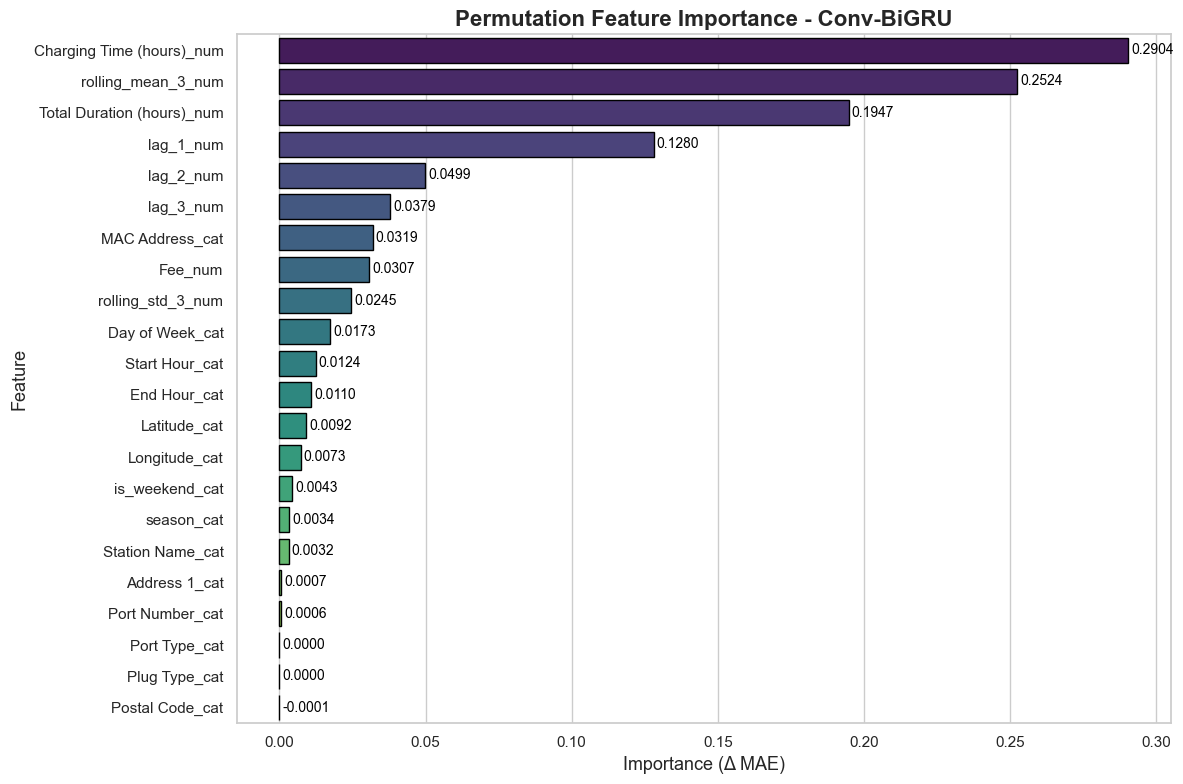

ValueError: Input 0 of layer "functional_12" is incompatible with the layer: expected shape=(None, 30), found shape=(51, 1, 30)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import seaborn as sns
import os

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Step 1: Add lag and rolling features
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()
df['log_target'] = np.log1p(df['smooth_target'])
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Step 2: Define column groups
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# Step 3: Encode and scale
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['log_target_scaled'] = target_scaler.fit_transform(df[['log_target']])

# Step 4: Prepare inputs
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['log_target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)

    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)

    rnn = Bidirectional(LSTM(64, return_sequences=True) if rnn_type == 'lstm' else GRU(64, return_sequences=True))(conv)
    attention = AttentionLayer()(rnn)
    x = Dropout(0.2)(attention)
    output = Dense(1)(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Train models
model_bilstm = build_model('lstm')
history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

model_bigru = build_model('gru')
history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

def permutation_importance(model, X_cat, X_num, y_true, input_func, categorical_cols, numerical_cols, metric=mean_absolute_error, n_repeats=3):
    base_input = input_func(X_cat, X_num)
    base_pred = model.predict(base_input).flatten()
    base_score = metric(y_true, base_pred)

    importances = []
    feature_names = []

    for i, col in enumerate(categorical_cols):
        scores = []
        for _ in range(n_repeats):
            X_cat_permuted = X_cat.copy()
            for t in range(X_cat.shape[1]):
                np.random.shuffle(X_cat_permuted[:, t, i])
            perm_input = input_func(X_cat_permuted, X_num)
            perm_pred = model.predict(perm_input).flatten()
            score = metric(y_true, perm_pred)
            scores.append(score)
        importances.append(np.mean(scores) - base_score)
        feature_names.append(f"{col}_cat")

    for i, col in enumerate(numerical_cols):
        scores = []
        for _ in range(n_repeats):
            X_num_permuted = X_num.copy()
            for t in range(X_num.shape[1]):
                np.random.shuffle(X_num_permuted[:, t, i])
            perm_input = input_func(X_cat, X_num_permuted)
            perm_pred = model.predict(perm_input).flatten()
            score = metric(y_true, perm_pred)
            scores.append(score)
        importances.append(np.mean(scores) - base_score)
        feature_names.append(f"{col}_num")

    return pd.DataFrame({"Feature": feature_names, "Importance": importances}).sort_values(by="Importance", ascending=False)

# Run permutation importance
perm_bilstm_df = permutation_importance(model_bilstm, X_cat_test, X_num_test, y_test, prepare_input, categorical_cols, numerical_cols)
perm_bigru_df = permutation_importance(model_bigru, X_cat_test, X_num_test, y_test, prepare_input, categorical_cols, numerical_cols)

# Fancy plots
def plot_fancy_permutation_importance(importance_df, title):
    plt.figure(figsize=(12, 8))
    sns.set(style="whitegrid")
    ax = sns.barplot(y="Feature", x="Importance", data=importance_df, palette="viridis", edgecolor="black")
    ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Importance (Δ MAE)", fontsize=13)
    ax.set_ylabel("Feature", fontsize=13)
    for i, v in enumerate(importance_df["Importance"]):
        ax.text(v + 0.001, i, f"{v:.4f}", color='black', va='center', fontsize=10)
    plt.tight_layout()
    plt.show()

plot_fancy_permutation_importance(perm_bilstm_df, "Permutation Feature Importance - Conv-BiLSTM")
plot_fancy_permutation_importance(perm_bigru_df, "Permutation Feature Importance - Conv-BiGRU")



# Integrated Gradients for Conv-BiLSTM and Conv-BiGRU

def integrated_gradients(model, baseline_input, target_input, steps=50):
    interpolated_inputs = {key: [] for key in target_input}

    for i in range(steps + 1):
        step_input = {}
        for key in target_input:
            baseline_tensor = tf.convert_to_tensor(baseline_input[key], dtype=tf.float32)
            target_tensor = tf.convert_to_tensor(target_input[key], dtype=tf.float32)
            step_tensor = baseline_tensor + (float(i) / steps) * (target_tensor - baseline_tensor)
            step_input[key] = step_tensor
        for key in step_input:
            interpolated_inputs[key].append(step_input[key][0])

    for key in interpolated_inputs:
        interpolated_inputs[key] = tf.convert_to_tensor(interpolated_inputs[key], dtype=tf.float32)

    with tf.GradientTape() as tape:
        for tensor in interpolated_inputs.values():
            tape.watch(tensor)
        preds = model({k: tf.expand_dims(v, axis=1) if 'input' in k else v for k, v in interpolated_inputs.items()})
        target = preds[:, 0]

    grads = tape.gradient(target, list(interpolated_inputs.values()))

    attributions = {}
    for i, key in enumerate(interpolated_inputs):
        if grads[i] is None:
            raise ValueError(f"Gradient for input {key} is None")
        avg_grads = tf.reduce_mean(grads[i], axis=0).numpy()
        delta_input = tf.convert_to_tensor(target_input[key][0], dtype=tf.float32) - tf.convert_to_tensor(baseline_input[key][0], dtype=tf.float32)
        attributions[key] = (delta_input * avg_grads).numpy()
    return attributions

def visualize_integrated_gradients(attributions, feature_labels, title):
    import seaborn as sns
    plt.figure(figsize=(10, 6))
    values = attributions['numerical_input'].mean(axis=0)
    sns.barplot(x=feature_labels, y=values, palette="coolwarm")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.ylabel("Attribution")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Choose a sample index and baseline
sample_idx = 0
baseline_cat = np.zeros_like(X_cat_test[sample_idx:sample_idx+1])
baseline_num = np.zeros_like(X_num_test[sample_idx:sample_idx+1])
input_sample = prepare_input(X_cat_test[sample_idx:sample_idx+1], X_num_test[sample_idx:sample_idx+1])
baseline_sample = prepare_input(baseline_cat, baseline_num)

# Run IG for BiLSTM
ig_attributions_bilstm = integrated_gradients(model_bilstm, baseline_sample, input_sample)
visualize_integrated_gradients(ig_attributions_bilstm, numerical_cols, "Integrated Gradients - Conv-BiLSTM")

# Run IG for BiGRU
ig_attributions_bigru = integrated_gradients(model_bigru, baseline_sample, input_sample)
visualize_integrated_gradients(ig_attributions_bigru, numerical_cols, "Integrated Gradients - Conv-BiGRU")


Feature Ablation For Shap based plots

Epoch 1/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2032 - mae: 0.3258
Epoch 1: val_loss improved from inf to 0.04664, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.2007 - mae: 0.3234 - val_loss: 0.0466 - val_mae: 0.1501
Epoch 2/50
74/77 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0536 - mae: 0.1668
Epoch 2: val_loss improved from 0.04664 to 0.03774, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0535 - mae: 0.1668 - val_loss: 0.0377 - val_mae: 0.1405
Epoch 3/50
76/77 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0450 - mae: 0.1554
Epoch 3: val_loss improved from 0.03774 to 0.02998, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0450 - mae: 0.1553 - val_loss: 0.0300 - val_mae: 0.1299
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0388 - mae: 0.1478
Epoch 4: val_loss improved from 0.02998 to 0.02299, saving model to temp_bilstm.keras
77/77 ━━━━━━━━━━━━━━━━

C:\Users\user\AppData\Local\Temp\ipykernel_24560\3001025563.py:208: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


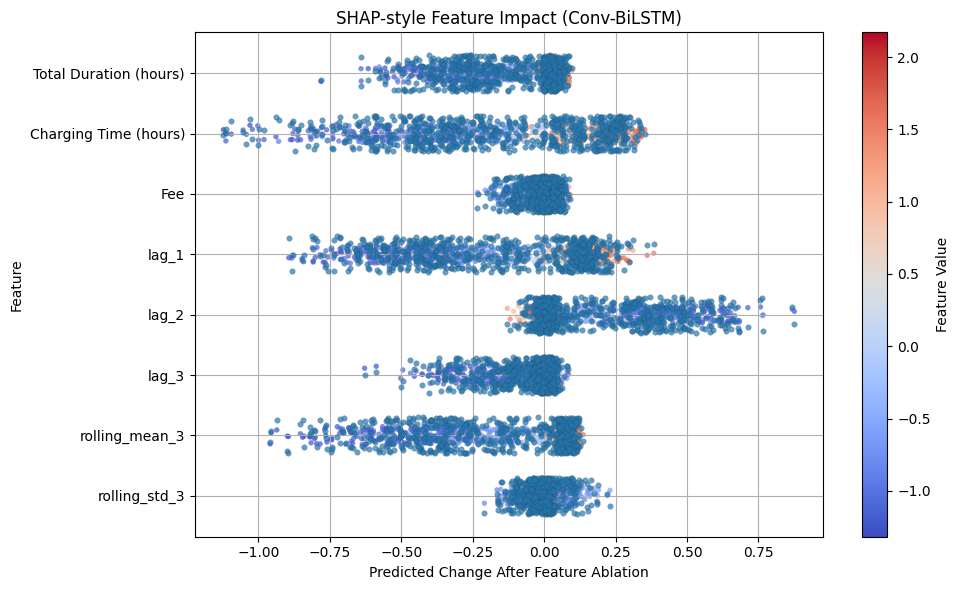


Generating SHAP-style ablation plot for Conv-BiGRU...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


C:\Users\user\AppData\Local\Temp\ipykernel_24560\3001025563.py:208: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


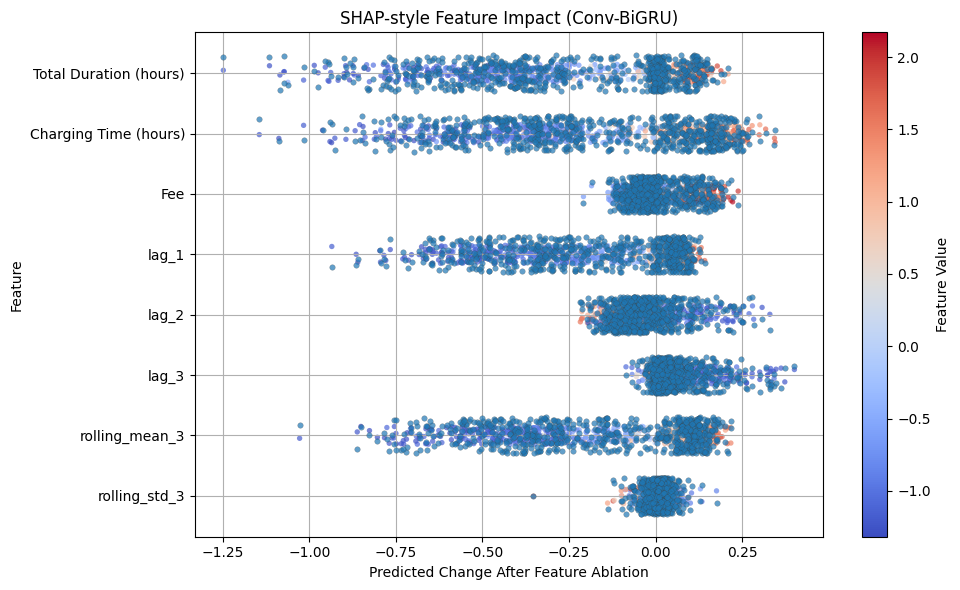

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
625/625 ━━━━━━

<Figure size 640x480 with 0 Axes>

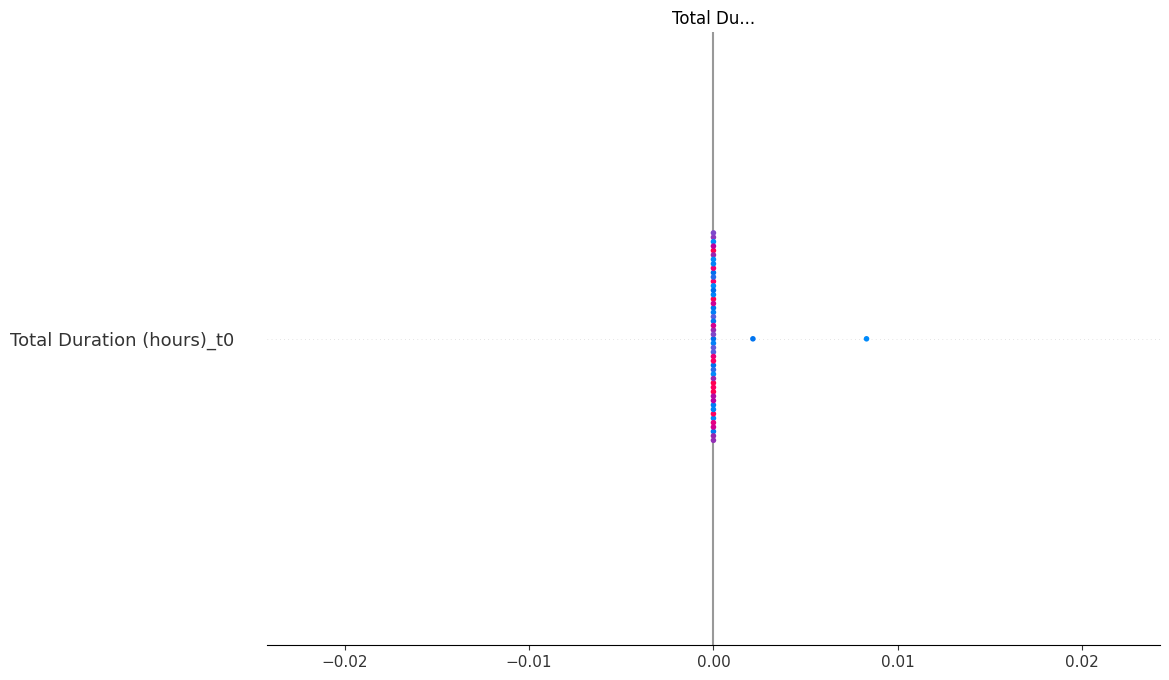

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Dropout, Concatenate, Conv1D, Bidirectional, LSTM, GRU, TimeDistributed
import os

# Load dataset
df = pd.read_csv("PaloAlto_Resampled_withWeekendSeason.csv")

# Step 1: Add lag and rolling features
for lag in range(1, 4):
    df[f'lag_{lag}'] = df['Energy (kWh)'].shift(lag)
df['rolling_mean_3'] = df['Energy (kWh)'].rolling(window=3).mean()
df['rolling_std_3'] = df['Energy (kWh)'].rolling(window=3).std()
df['smooth_target'] = df['Energy (kWh)'].rolling(window=3, min_periods=1).mean()
df['log_target'] = np.log1p(df['smooth_target'])
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Step 2: Define column groups
categorical_cols = ['Station Name', 'MAC Address', 'Port Type', 'Port Number', 'Plug Type', 'Address 1', 'Postal Code', 'Latitude', 'Longitude',
                    'Start Hour', 'End Hour', 'Day of Week', 'is_weekend', 'season']
numerical_cols = ['Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'rolling_std_3']

# Step 3: Encode and scale
encoder = OrdinalEncoder()
df[categorical_cols] = encoder.fit_transform(df[categorical_cols]).astype(int)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
target_scaler = StandardScaler()
df['log_target_scaled'] = target_scaler.fit_transform(df[['log_target']])

# Step 4: Prepare inputs
X_cat = df[categorical_cols].values
X_num = df[numerical_cols].values
y = df['log_target_scaled'].values

def create_sequences(X_cat, X_num, y, time_steps=30):
    Xs_cat, Xs_num, ys = [], [], []
    for i in range(len(X_cat) - time_steps):
        Xs_cat.append(X_cat[i:i + time_steps])
        Xs_num.append(X_num[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs_cat), np.array(Xs_num), np.array(ys)

X_cat_seq, X_num_seq, y_seq = create_sequences(X_cat, X_num, y)
X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    X_cat_seq, X_num_seq, y_seq, test_size=0.2, random_state=42)

# Step 5: Embedding and model setup
embedding_info = {col: int(df[col].nunique()) + 1 for col in categorical_cols}
embedding_dims = {col: min(50, (n_cat + 1) // 2) for col, n_cat in embedding_info.items()}

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Step 6: Define attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)

    def call(self, inputs):
        score = tf.matmul(inputs, self.W)
        weights = tf.nn.softmax(score, axis=1)
        context = tf.reduce_sum(inputs * weights, axis=1)
        return context

# Step 7: Build model with attention
def build_model(rnn_type='lstm'):
    cat_inputs = [Input(shape=(30,), name=f"{col}_input") for col in categorical_cols]
    num_input = Input(shape=(30, len(numerical_cols)), name="numerical_input")

    embeddings = [Embedding(input_dim=embedding_info[col], output_dim=embedding_dims[col])(inp)
                  for col, inp in zip(categorical_cols, cat_inputs)]
    embedded = Concatenate(axis=-1)(embeddings)
    embedded = TimeDistributed(Flatten())(embedded)

    merged = Concatenate(axis=-1)([embedded, num_input])
    conv = Conv1D(filters=32, kernel_size=1, activation='relu')(merged)

    rnn = Bidirectional(LSTM(64, return_sequences=True) if rnn_type == 'lstm' else GRU(64, return_sequences=True))(conv)
    attention = AttentionLayer()(rnn)
    x = Dropout(0.2)(attention)
    output = Dense(1)(x)

    model = Model(inputs=cat_inputs + [num_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def prepare_input(X_cat, X_num):
    return {f"{col}_input": X_cat[:, :, i] for i, col in enumerate(categorical_cols)} | {'numerical_input': X_num}

train_inputs = prepare_input(X_cat_train, X_num_train)
test_inputs = prepare_input(X_cat_test, X_num_test)

# Define temp paths
temp_path_bilstm = "temp_bilstm.keras"
temp_path_bigru = "temp_bigru.keras"

# Train models
checkpoint_bilstm = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bilstm, save_best_only=True, monitor="val_loss", mode="min", verbose=1)
checkpoint_bigru = tf.keras.callbacks.ModelCheckpoint(filepath=temp_path_bigru, save_best_only=True, monitor="val_loss", mode="min", verbose=1)

# Conv-BiLSTM
model_bilstm = build_model('lstm')
history_bilstm = model_bilstm.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                  validation_split=0.1, callbacks=[checkpoint_bilstm], verbose=1)

# Conv-BiGRU
model_bigru = build_model('gru')
history_bigru = model_bigru.fit(train_inputs, y_train, epochs=50, batch_size=32,
                                validation_split=0.1,callbacks=[checkpoint_bigru], verbose=1)

# Delete both temp files if needed
for path in [temp_path_bilstm, temp_path_bigru]:
    if os.path.exists(path):
        os.remove(path)
        print(f"Deleted: {path}")

# Step 7: Predict
y_pred_bilstm = model_bilstm.predict(test_inputs).flatten()
y_pred_bigru = model_bigru.predict(test_inputs).flatten()

# Step 8: Evaluation (normalized)
def evaluate_normalized(y_true, y_pred, name):
    print(f"\n{name} Performance (Normalized Log Scale):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")


# Step 9: Inverse transform to original scale
def inverse_log_scaled(pred):
    return np.expm1(target_scaler.inverse_transform(pred.reshape(-1, 1))).flatten()

y_test_orig = inverse_log_scaled(y_test)
y_pred_bilstm_orig = inverse_log_scaled(y_pred_bilstm)
y_pred_bigru_orig = inverse_log_scaled(y_pred_bigru)

# Step 10: Evaluation (original scale)
def evaluate_original(y_true, y_pred, name):
    print(f"\n{name} Performance (Original Scale - kWh):")
    print(f"  MSE : {mean_squared_error(y_true, y_pred):.6f}")
    print(f"  MAE : {mean_absolute_error(y_true, y_pred):.6f}")
    print(f"  RMSE: {sqrt(mean_squared_error(y_true, y_pred)):.6f}")
    print(f"  MAPE: {mean_absolute_percentage_error(y_true, y_pred) * 100:.6f}")
    print(f"  R²  : {r2_score(y_true, y_pred):.6f}")

import seaborn as sns
import pandas as pd

# --- SHAP-style Feature Ablation Visualization ---

# Function to collect per-sample ablation impacts
def collect_samplewise_ablation(model, X_cat_test, X_num_test, feature_names, original_preds):
    all_deltas = []

    for i, feature in enumerate(feature_names):
        X_num_modified = X_num_test.copy()
        feature_values = X_num_modified[:, :, i].mean(axis=1)  # Average value over time steps
        X_num_modified[:, :, i] = 0  # Zero-out the current feature

        # Prepare modified inputs
        test_inputs_modified = {f"{col}_input": X_cat_test[:, :, j] for j, col in enumerate(categorical_cols)}
        test_inputs_modified['numerical_input'] = X_num_modified

        # Predict with modified input
        y_pred_modified = model.predict(test_inputs_modified).flatten()
        delta = original_preds - y_pred_modified  # Change in prediction

        # Store sample-wise impacts
        for j in range(len(delta)):
            all_deltas.append({
                "Feature": feature,
                "Impact": delta[j],
                "Value": feature_values[j]
            })

    return pd.DataFrame(all_deltas)

# Function to plot SHAP-style beeswarm plot
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def plot_shap_style_beeswarm_with_colorbar(ablation_df, title="SHAP-style Feature Impact"):
    plt.figure(figsize=(10, 6))

    # Normalize and map colors
    norm = Normalize(vmin=ablation_df["Value"].min(), vmax=ablation_df["Value"].max())
    cmap = plt.get_cmap("coolwarm")
    colors = cmap(norm(ablation_df["Value"]))

    # Create the beeswarm-style plot
    sns.stripplot(
        x="Impact",
        y="Feature",
        data=ablation_df,
        palette=None,
        size=4,
        jitter=0.3,
        alpha=0.7,
        edgecolor="gray",
        linewidth=0.2
    )

    # Overlay each point with mapped color manually
    ax = plt.gca()
    for i, feature in enumerate(ablation_df["Feature"].unique()):
        subset = ablation_df[ablation_df["Feature"] == feature]
        x_vals = subset["Impact"].values
        y_vals = np.full_like(x_vals, i, dtype=float) + np.random.uniform(-0.15, 0.15, size=len(x_vals))
        ax.scatter(x_vals, y_vals, c=cmap(norm(subset["Value"].values)), s=15, alpha=0.7, edgecolors='none')

    # Add color bar
    sm = ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label("Feature Value")

    plt.title(title)
    plt.xlabel("Predicted Change After Feature Ablation")
    plt.ylabel("Feature")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# --- Run Ablation for Conv-BiLSTM ---
print("\nGenerating SHAP-style ablation plot for Conv-BiLSTM...")
df_bilstm_ablation = collect_samplewise_ablation(
    model_bilstm,
    X_cat_test,
    X_num_test,
    numerical_cols,
    y_pred_bilstm
)

plot_shap_style_beeswarm_with_colorbar(df_bilstm_ablation, title="SHAP-style Feature Impact (Conv-BiLSTM)")

# --- Optional: Run for Conv-BiGRU ---
print("\nGenerating SHAP-style ablation plot for Conv-BiGRU...")
df_bigru_ablation = collect_samplewise_ablation(
    model_bigru,
    X_cat_test,
    X_num_test,
    numerical_cols,
    y_pred_bigru
)

plot_shap_style_beeswarm_with_colorbar(df_bigru_ablation, title="SHAP-style Feature Impact (Conv-BiGRU)")


C:\Users\user\AppData\Local\Temp\ipykernel_25148\3575232678.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df.rename(columns={'Total Duration (hours)': 'Total_time', 'Charging Time (hours)': 'Charge_time', 'Energy (kWh)': 'Energy'}, inplace=True)


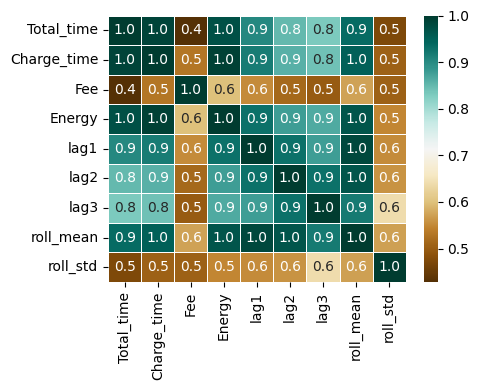

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('PaloAlto_Resampled_withWeekendSeason.csv')

# Ensure the data is sorted by date if necessary
# df['Date'] = pd.to_datetime(df['Date'])
# df = df.sort_values('Date')

# Create lag features
df['lag1'] = df['Energy (kWh)'].shift(1)
df['lag2'] = df['Energy (kWh)'].shift(2)
df['lag3'] = df['Energy (kWh)'].shift(3)

# Create rolling features (window=3, center=False)
df['roll_mean'] = df['Energy (kWh)'].rolling(window=3).mean()
df['roll_std'] = df['Energy (kWh)'].rolling(window=3).std()

# Select relevant columns
selected_columns = [
    'Total Duration (hours)', 'Charging Time (hours)', 'Fee', 'Energy (kWh)',
    'lag1', 'lag2', 'lag3', 'roll_mean', 'roll_std'
]
selected_df = df[selected_columns]
selected_df.rename(columns={'Total Duration (hours)': 'Total_time', 'Charging Time (hours)': 'Charge_time', 'Energy (kWh)': 'Energy'}, inplace=True)

# Drop rows with NaN from lag/rolling calculation
selected_df = selected_df.dropna()

# Compute correlation matrix
correlation_matrix = selected_df.corr()

# Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, fmt='.1f', cmap='BrBG', linewidths=0.5)
#plt.title('Correlation Heatmap: Palo Alto')
plt.tight_layout()
plt.show()


In [33]:
import pandas as pd
import plotly.express as px

# Load dataset
df = pd.read_csv('PaloAlto_Resampled_withWeekendSeason.csv')

# Explicit categorical columns
explicit_categorical = ['Start Hour', 'End Hour', 'Day of Week', 'season', 'is_weekend']

# Find object-type columns
object_categoricals = df.select_dtypes(include=['object']).columns.tolist()

# Combine and deduplicate
categorical_columns = list(set(explicit_categorical + object_categoricals))

# Select columns for plot
parallel_cols = categorical_columns + ['Energy (kWh)']

# Create the parallel categories plot
fig = px.parallel_categories(df[parallel_cols], color='Energy (kWh)',
                             color_continuous_scale=px.colors.sequential.Viridis,
                             labels={'Energy (kWh)': 'Energy (kWh)'},
                             dimensions=categorical_columns)

# Update layout for title
fig.update_layout(title='Parallel Categories Plot: Categorical Features vs Energy (kWh)')

# Show plot
fig.show()
